In [1]:
import alpaca_trade_api as tradeapi
import pandas as pd
import numpy as np
import statsmodels.tsa.stattools as sm
from scipy.stats import shapiro, pearsonr
from pykalman import KalmanFilter
import math
from scipy.stats import linregress
import itertools
from matplotlib import pyplot as plt
import scipy

C:\Users\ogni\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ogni\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\ogni\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [21]:
stock_1 = 'GM'
stock_2 = 'F'

NY = 'America/New_York'

#must be <150 days apart
start_input = '2012-1-1 9:30'
end_input = '2012-7-1 16:00'

HEDGE_LOOKBACK = 21
MIN_WEIGHT = 0.2
DESIRED_PVALUE = 0.01

In [22]:
API = tradeapi.REST(
 base_url="https://paper-api.alpaca.markets",
 key_id="PKSL6HFOBBRWI3ZYB3CE",
 secret_key="oFil1E/0DN1WTatQMGoo6YahQXudVRED9t6dBNbV"
)

start_date=pd.Timestamp(start_input, tz=NY).isoformat()
end_date=pd.Timestamp(end_input, tz=NY).isoformat()

s1_data = API.get_barset([stock_1], 'day', start=start_date, end=end_date).df
s1_price = s1_data[stock_1]['close'].values.tolist()

s2_data = API.get_barset([stock_2], 'day', start=start_date, end=end_date).df
s2_price = s2_data[stock_2]['close'].values.tolist()

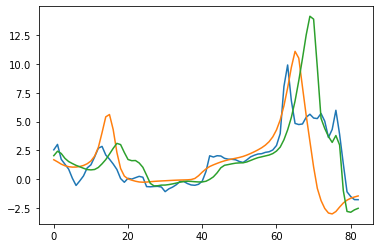

In [23]:
def linreg(s1,s2):
    try:
        slope, intercept, rvalue, pvalue, stderr = linregress(s1,s2)
    except:
        try:
            print('polyfit')
            reg = np.polynomial.polynomial.polyfit(s1,s2)
            slope = reg[1]
            intercept = reg[0]
        except:
            try:
                print('sm')
                s1 = sm.add_constant(s1)
                model = sm.OLS(s2, s1).fit()
                intercept = model.params[0]
                slope = model.params[1]
            except:
                print('Linear Regression Failed')
                slope = float('NaN')
                intercept = float('NaN')
    return slope, intercept

def get_spreads(s1_price, s2_price):
    length = len(s1_price)-(2*HEDGE_LOOKBACK)
    residuals = []
    zscores = []
    for i in range(1, HEDGE_LOOKBACK):
        start_index = len(s1_price) - length - HEDGE_LOOKBACK + i
        hedge, intercept = linreg(s2_price[start_index-HEDGE_LOOKBACK:start_index], 
                                  s1_price[start_index-HEDGE_LOOKBACK:start_index])
        residuals = np.append(residuals, s1_price[i] - hedge*s2_price[i] + intercept)
        
    for i in range(length):
        start_index = len(s1_price) - length + i
        hedge, intercept = linreg(s2_price[start_index-HEDGE_LOOKBACK:start_index], 
                                  s1_price[start_index-HEDGE_LOOKBACK:start_index])
        current_residual = s1_price[i] - hedge*s2_price[i] + intercept
        residuals = np.append(residuals, current_residual)
        std = np.std(residuals[-HEDGE_LOOKBACK:])
        zscores = np.append(zscores, current_residual/std)
    return zscores

def run_kalman_smooth(price_history):
    kf_stock = KalmanFilter(transition_matrices = [1], observation_matrices = [1], initial_state_mean = price_history[0], 
                            initial_state_covariance = 1, observation_covariance=1, transition_covariance=.05)
    return kf_stock.smooth(price_history)[0].flatten()

def run_kalman_filter(price_history):
    kf_stock = KalmanFilter(transition_matrices = [1], observation_matrices = [1], initial_state_mean = price_history[0], 
                            initial_state_covariance = 1, observation_covariance=1, transition_covariance=.05)
    return kf_stock.filter(price_history)[0].flatten()

s1_price_s = run_kalman_smooth(s1_price)
s2_price_s = run_kalman_smooth(s2_price)

s1_price_f = run_kalman_filter(s1_price)
s2_price_f = run_kalman_filter(s2_price)

spreads_s = get_spreads(s1_price_s,s2_price_s)
spreads_f = get_spreads(s1_price_f,s2_price_f)
spreads = get_spreads(s1_price,s2_price)

plt.plot(spreads)
plt.plot(spreads_s)
plt.plot(spreads_f)

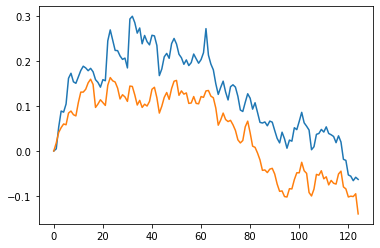

In [24]:
s1_perc = [(val-s1_price[0])/s1_price[0] for val in s1_price]
s2_perc = [(val-s2_price[0])/s2_price[0] for val in s2_price]
plt.plot(s1_perc)
plt.plot(s2_perc)

In [25]:
def correlation1(a,b):
    r, p = pearsonr(a,b)
    if p<DESIRED_PVALUE:
        return r
    else:
        return float('NaN')
    return r

def cointegration1(a, b):
    score, pvalue, _ = sm.coint(a, b)
    return pvalue

def adf_pvalue1(spreads, s1_price, s2_price):
    if min(sm.adfuller(s1_price,autolag="t-stat")[1], sm.adfuller(s2_price,autolag="t-stat")[1])>DESIRED_PVALUE:
        return sm.adfuller(spreads,autolag="t-stat")[1]
    else:
        return float('NaN')

def hurst_hvalue1(series):
    max_window = len(series)-1
    min_window = 10
    window_sizes = list(map(lambda x: int(10**x),np.arange(math.log10(min_window), math.log10(max_window), 0.25)))
    window_sizes.append(len(series))
    RS = []
    for w in window_sizes:
        rs = []
        for start in range(0, len(series), w):
            if (start+w)>len(series):
                break
            incs = series[start:start+w][1:] - series[start:start+w][:-1]

#             # SIMPLIFIED
#             R = max(series[start:start+w]) - min(series[start:start+w])  # range in absolute values
#             S = np.std(incs, ddof=1) 

            #NOT SIMPLIFIED
            mean_inc = (series[start:start+w][-1] - series[start:start+w][0]) / len(incs)
            deviations = incs - mean_inc
            Z = np.cumsum(deviations)
            R = max(Z) - min(Z)
            S = np.std(incs, ddof=1)

            if R != 0 and S != 0:
                rs.append(R/S)
        RS.append(np.mean(rs))
    A = np.vstack([np.log10(window_sizes), np.ones(len(RS))]).T
    H, c = np.linalg.lstsq(A, np.log10(RS), rcond=-1)[0]
    return H

def half_life1(spreads): 
    spreads = spreads[-HEDGE_LOOKBACK::]
    lag = np.roll(spreads, 1)
    ret = spreads - lag
    return(-np.log(2) / linregress(lag, ret).slope)

def shapiro_pvalue1(spreads):
    w, p = shapiro(spreads)
    return p

def zscore1(spreads):
    return spreads

def alpha1(price1, price2):
    slope, intercept, rvalue, pvalue, stderr = linregress(price2, price1)
    y_target_shares = 1
    x_target_shares = -slope
    notionalDol =  abs(y_target_shares * price1[-1]) + abs(x_target_shares * price2[-1])
    (y_target_pct, x_target_pct) = (y_target_shares * price1[-1] / notionalDol, x_target_shares * price2[-1] / notionalDol)
    if (abs(x_target_pct) > MIN_WEIGHT) and (abs(y_target_pct) > MIN_WEIGHT) and (pvalue<DESIRED_PVALUE):
        return slope
    else:
        return float('NaN')

def adf_prices1(s1_price, s2_price):
    p1 = sm.adfuller(s1_price,autolag="t-stat")[1]
    p2 = sm.adfuller(s2_price,autolag="t-stat")[1]
    return min(p1,p2)

correlation = correlation1(s1_price, s2_price)
cointegration = cointegration1(s1_price, s2_price)
adf_pvalue = adf_pvalue1(spreads, s1_price, s2_price)
hurst_hvalue = hurst_hvalue1(spreads)
half_life = half_life1(spreads)
shapiro_pvalue = shapiro_pvalue1(spreads)
alpha = alpha1(s1_price, s2_price)
adf_prices=adf_prices1(s1_price, s2_price)

print('Correlation',correlation)
print('Cointegration',cointegration)
print('ADF', adf_pvalue)
print('Hurst', hurst_hvalue)
print('Half Life', half_life)
print('Shapiro Wilk',shapiro_pvalue)
print('Alpha',alpha)
print('ADF-Prices',adf_prices)

Correlation 0.9334244414656492
Cointegration 0.023057251615543083
ADF 0.36789331545099213
Hurst 0.6550027813340713
Half Life 2.0993437728497173
Shapiro Wilk 0.00014220364391803741
Alpha 1.836396146870008
ADF-Prices 0.9477487131471821


(array([12., 19., 14., 19.,  5.,  5.,  6.,  1.,  1.,  1.]),
 array([-1.77915172, -0.6105815 ,  0.55798872,  1.72655895,  2.89512917,
         4.06369939,  5.23226961,  6.40083983,  7.56941005,  8.73798027,
         9.90655049]),
 <a list of 10 Patch objects>)

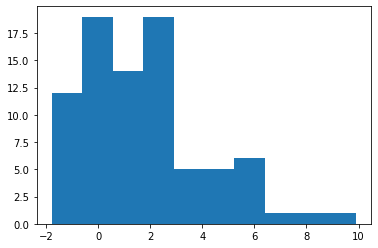

In [26]:
plt.hist(spreads)